### Set up

In [1]:
from instruct_sam.instruct_sam import InstructSAM
from instruct_sam.matching import init_clip_model
from instruct_sam.visualize import visualize_prediction
import yaml
import openai

openai.api_key = 'your_api_key'
openai.base_url = "base_url"

#### Init CLIP

In [2]:
device = "cuda:0"
print(device)
clip_model = 'georsclip'
ckpt_config = '../checkpoints/config.yaml'
with open(ckpt_config, 'r') as f:
    ckpt_config = yaml.safe_load(f)
ckpt_path = ckpt_config[clip_model]
model, tokenizer, preprocess = init_clip_model(clip_model, device, ckpt_path)

cuda:0


#### Init SAM2

In [3]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "your_checkpoint_path"
model_cfg = "your_model_config_path"
sam2 = build_sam2(model_cfg, sam2_checkpoint,
                  device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2, pred_iou_thresh=0.75, stability_score_thresh=0.75,
                                            points_per_side=24, crop_n_layers=1, box_nms_thresh=0.5)


#### Iinit Inferencer

In [4]:
instruct_sam = InstructSAM()

### Inference

#### Remote Sensing Image

In [5]:
image_path = '../datasets/dior/JPEGImages-trainval/09938.jpg'
instruct_sam.set_image(image_path)

prompt = """
{
    "Persona": "You are an advanced AI model capable of understanding and analyzing remote sensing images.",
    "Task": "Given an input satellite imagery, count the number of all the visible remote sensing objects or scenes. Provide the results in JSON format where the keys are the category names and the values are the corresponding counts.",
    "Instructions": [
        "The spatial resolution of the imagery in the dataset ranges from 0.3 m to 30 m.",
        "If the resolution is too limited or the scene is too dense to accurately count certain objects, exclude those objects from the results.",
        "Only count objects that are clearly visible in the imagery."],
    "Output format": "{ "category1": count1, "category2": count2, ... }",
    "Answer": [
        "Ensure the category names are in singular form",
        "Provide the counts as integers."]
}
"""
instruct_sam.count_objects(prompt, gpt_model="gpt-4o-2024-11-20", json_output=True)
print(f'response: \n{instruct_sam.response}')


response: 
{
    "car": 23,
    "building": 5,
    "basketball_court": 2,
    "tennis_court": 1
}


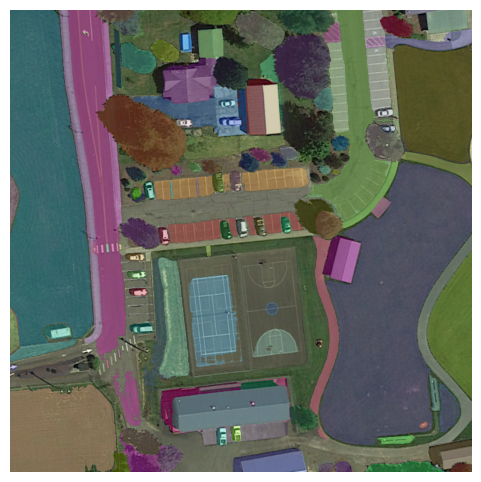

128

In [6]:
instruct_sam.segment_anything(mask_generator, max_masks=200)
instruct_sam.show_masks()
instruct_sam.num_masks

Visualization of similarity scores. The label assigned to each region (mask) proposal represents the category with the highest similarity to that proposal.
> Note: This may differ from the final matching results, as the matching process is constrained by object counts.

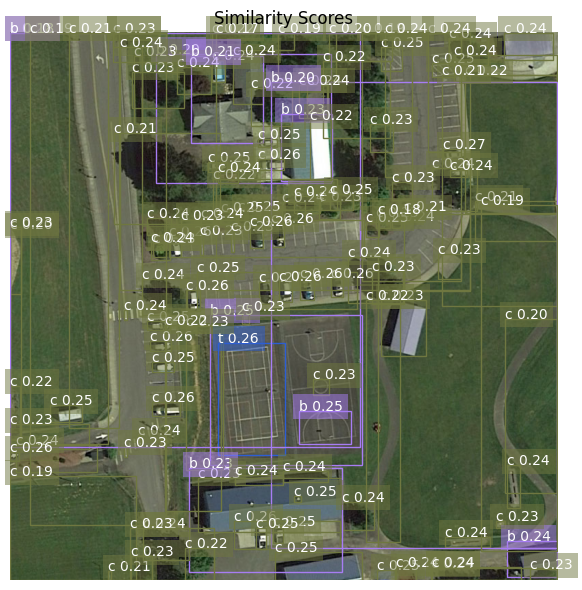

In [7]:
instruct_sam.calculate_pred_text_features(model, tokenizer, use_vocab=False)
instruct_sam.match_boxes_and_labels(model, preprocess, show_similarities=True);

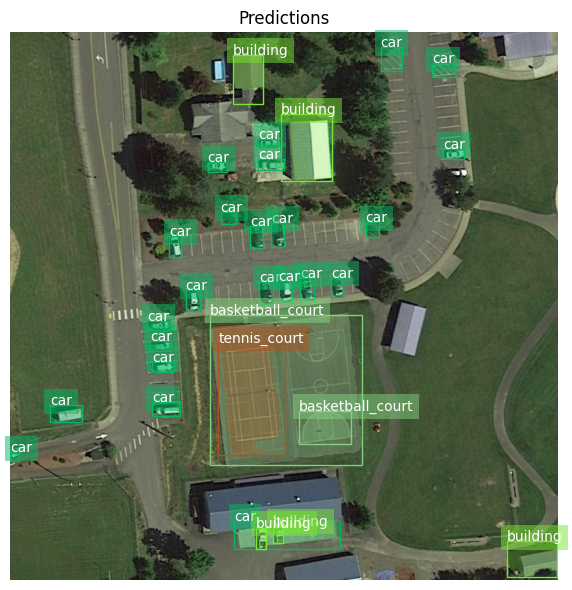

In [8]:
visualize_prediction(instruct_sam.img_array, instruct_sam.boxes_final,
                     instruct_sam.labels_final, instruct_sam.segmentations_final,
                     dpi=100)
# save image
box_final = instruct_sam.boxes_final
label_final = instruct_sam.labels_final

#### Natural Image

Equipped with generic CLIP model, InstructSAM can recognize objects in natural images.

In [9]:
clip_model = 'dfn2b'
ckpt_config = '../checkpoints/config.yaml'
with open(ckpt_config, 'r') as f:
    ckpt_config = yaml.safe_load(f)
ckpt_path = ckpt_config[clip_model]
model, tokenizer, preprocess = init_clip_model(clip_model, device, ckpt_path)

In [10]:
image_path = './chip.jpg'
instruct_sam.set_image(image_path)

prompt = """
{
    "Persona": "You are an advanced AI model capable of understanding and analyzing images."
    "Task": "Given an input imagery, count the number of visible objects that belong to the parent category **electronic componets**. Provide the results in JSON format where the keys are the names of the subcategories and the values are the corresponding counts.",
    "Output format": "{ "subcategory1": count1, "subcategory2": count2, ... }",
    "Answer": ["Ensure the category names are in singular form",
                "Provide the counts as integers."]
}
"""
instruct_sam.count_objects(prompt, gpt_model="gpt-4o-2024-11-20", json_output=True)
print(f'response: \n{instruct_sam.response}')

response: 
{
    "capacitor": 18,
    "resistor": 15,
    "inductor": 2,
    "integrated_circuit": 2
}


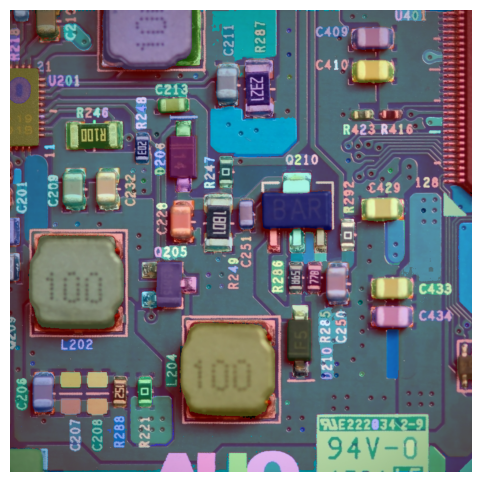

200

In [11]:
instruct_sam.segment_anything(mask_generator, max_masks=200)
instruct_sam.show_masks()
instruct_sam.num_masks

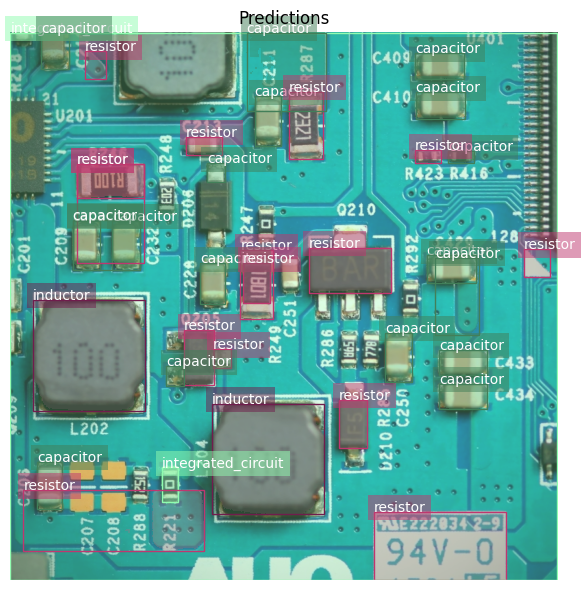

In [12]:
instruct_sam.calculate_pred_text_features(model, tokenizer, use_vocab=False);
instruct_sam.match_boxes_and_labels(model, preprocess, show_similarities=False);

visualize_prediction(instruct_sam.img_array, instruct_sam.boxes_final,
                     instruct_sam.labels_final, instruct_sam.segmentations_final,
                     dpi=100)
# save image
box_final = instruct_sam.boxes_final
label_final = instruct_sam.labels_final